## Goal: to manipulate raw crime data to take a look at violent crime between 2016-2018
##### Assumptions: There is more than 1 person involved in a crime, sometimes more than 1 suspect. We will only be looking at suspects 

In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns=200
pd.options.display.max_rows=1000 

%matplotlib inline 

In [2]:
# try using glob later 
# https://stackoverflow.com/questions/56990908/read-and-save-multiple-csv-files-from-a-for-loop
data_paths = [['data_16','KCPD_Crime_Data_2016.csv'],
              ['data_17','KCPD_Crime_Data_2017.csv'],
              ['data_18','KCPD_Crime_Data_2018.csv']]
    
df_dct = {name:pd.read_csv(str('raw-crime-data/')+filepath,
                      dtype = {"Zip Code":object, 
                               'Report_No':object, 
                              'Report_No':object,
                              'Offense':object}) for name, filepath in data_paths}
df = pd.concat([pd.concat(df_dct, sort = False)]).reset_index()
df.columns = df.columns.str.replace(' ', '_')
df.columns = map(str.lower, df.columns)
df.columns = df.columns.str.replace('/', '_')
df.columns = df.columns.str.replace('-', '_')
df,df = df.drop(columns = ['level_1']), df.rename(columns = {'level_0' : 'source_df'})

In [3]:
df.dtypes

source_df             object
level_1                int64
report_no             object
reported_date         object
reported_time         object
from_date             object
from_time             object
to_date               object
to_time               object
offense               object
ibrs                  object
description           object
beat                 float64
address               object
city                  object
zip_code              object
rep_dist              object
area                  object
dvflag                object
invl_no                int64
involvement           object
race                  object
sex                   object
age                  float64
firearm_used_flag     object
location              object
dtype: object

In [4]:
# check lengths
for key in df_dct:
    print(str(key)+":",len(df_dct[key]))
    
print('length of all df: ', len(df))

data_16: 127877
data_17: 132139
data_18: 128938
length of all df:  388954


In [5]:
# droping certian data
print('droping {} rows where race = *'.format(len(df[df.race == '*'])))
df = df[df.race != '*']
print(len(df))
print('dropping {} rows because their age greater than 100 and that seems unlikely'.format(len(df[df.age >= 100])))
df = df[df.age <= 100]

droping 3 rows where race = *
388951
dropping 88 rows because their age greater than 100 and that seems unlikely


In [6]:
df.to_csv('crime_data_16_18_raw.csv')

### Create an aggregated datatable
##### Trying to have one line per case

In [7]:
violent_crimes = ['HOMICIDE/Non Neglige','Non Agg Assault Dome','Aggravated Assault (','Non Aggravated Assau','Armed Robbery',
                  'Agg Assault - Domest','Strong Arm Robbery','Agg Assault - Drive-','Justifiable Homicide','Agg Assault',
                  'Agg Assault Dome','NON AGG ASSAULT DV','strong armed robbery','non aggravated assau']

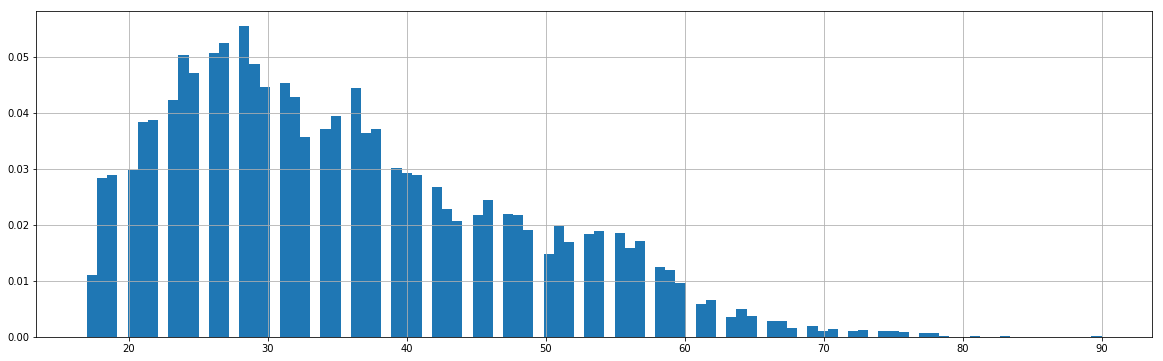

In [8]:
df_agg = df

def involmentFlag(role):
    x = np.where(df_agg.involvement == role,1,0)
    return x 

def raceFlag(race):
    x = np.where(df.race == race,1,0)
    return x

def ageFlag(min_age,max_age):
    x = np.where((df.age >= min_age) & (df.age <= max_age), 1,0)
    return x 
    
# involment
df_agg['arr_flag'] = involmentFlag('ARR')
df_agg['vic_flag'] = involmentFlag('VIC')
df_agg['sus_flag'] = involmentFlag('SUS')
# gender 
df_agg['male_flag'] = np.where(df.sex == "M",1,0)
df_agg['female_flag'] = np.where(df.sex == "F",1,0)
# race 
race_cols = [['black_race_flag', 'B'], ['nan_race_flag','nan'],['unknown_race_flag', 'U'],['white_race_flag','W'],
            ['asian_race_flag','A'],['indian_race_flag', 'I'], ['pacific_race_flag', 'P']]

for name,race in race_cols:
    df_agg[name] = raceFlag(race)
    
# gun
df_agg.firearm_used_flag = np.where(df_agg.firearm_used_flag == 'Y',1,0)

# dv
df_agg.dvflag = np.where(df_agg.dvflag == 'Y',1,0)
# age
# thinking behind age buckets 
df[(df.age<= 100) & 
   (df.description.isin(violent_crimes)== True) & 
   (df.involvement.isin(['ARR']) == True)].age.hist(bins=100,figsize=[20,6], 
                                                          density = True)

age_cols = [['age_minor', 16,17], ['age_18_24',18,24],['age_25_29',25,29], ['age_30_34',30,34],['age_35_39',35,39],
           ['age_40_44',40,44],['age_45_49',45,49],['age_50_plus',50,100]]

for name,age1,age2 in age_cols:
    df_agg[name] = ageFlag(age1,age2)
    
# since one report number can have more than one charge, make a report charge id
df_agg['charge_id'] = df_agg.report_no + df_agg.ibrs # not gonna work, for each description I need some sort of random number


In [9]:
df_agg.head(10)

,source_df,level_1,report_no,reported_date,reported_time,from_date,from_time,to_date,to_time,offense,ibrs,description,beat,address,city,zip_code,rep_dist,area,dvflag,invl_no,involvement,race,sex,age,firearm_used_flag,location,arr_flag,vic_flag,sus_flag,male_flag,female_flag,black_race_flag,nan_race_flag,unknown_race_flag,white_race_flag,asian_race_flag,indian_race_flag,pacific_race_flag,age_minor,age_18_24,age_25_29,age_30_34,age_35_39,age_40_44,age_45_49,age_50_plus,charge_id
0,data_16,0,100034831,10/18/2016,20:35,10/18/2016,20:35,NaN,NaN,1352,280,Stolen Property OFFE,212.0,CLEVELAND AV and E GREGORY BL,KANSAS CITY,64130,PJ5365,MPD,0,1,ARR,B,M,27.0,0,"E CLEVELAND BL KANSAS CITY, AV 64130\n(38.9983...",1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,100034831280
2,data_16,2,120084496,5/28/2016,23:29,5/28/2016,23:29,NaN,NaN,1352,280,Stolen Property OFFE,342.0,JACKSON AV and E LINWOOD BL,KANSAS CITY,64128,PJ2602,EPD,0,1,VIC,B,M,35.0,0,"E JACKSON BL KANSAS CITY, AV 64128\n(39.0675, ...",0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,120084496280
4,data_16,4,130056370,7/4/2016,1:37,7/3/2016,23:10,7/4/2016,0:47,1849,35A,Possession/Sale/Dist,NaN,8500 BLUE PARKWAY,KANSAS CITY,64133,NaN,NaN,0,2,ARR,B,M,50.0,0,8500 BLUE PARKWAY\nKANSAS CITY 64133\n(39.0078...,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,13005637035A
6,data_16,6,130087589,7/8/2016,11:41,NaN,NaN,NaN,NaN,101,09A,HOMICIDE/Non Neglige,344.0,E 33 TE and OAKLEY AV,KANSAS CITY,64129,PJ2769,EPD,0,1,VIC,W,F,34.0,0,33 TE and OAKLEY AV\nKANSAS CITY 64129\n(39.03...,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,13008758909A
7,data_16,7,130091019,8/4/2016,13:55,8/4/2016,13:50,NaN,NaN,2601,90Z,Misc Violation,532.0,11100 BLUE RIDGE BL,KANSAS CITY,64134,PJ7111,SPD,0,1,VIC,W,M,57.0,0,11100 BLUE RIDGE\nBL KANSAS CITY 64134\n(38.92...,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,13009101990Z
8,data_16,8,130091019,8/4/2016,13:55,8/4/2016,13:50,NaN,NaN,2601,90Z,Misc Violation,532.0,11100 BLUE RIDGE BL,KANSAS CITY,64134,PJ7111,SPD,0,1,SUS,B,M,52.0,0,11100 BLUE RIDGE\nBL KANSAS CITY 64134\n(38.92...,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,13009101990Z
10,data_16,10,140029511,3/21/2016,9:54,3/19/2016,8:08,NaN,8:59,840,90Z,Resisting an Officer,531.0,9700 MARION PARK DR,KANSAS CITY,64137,PJ6588,SPD,0,1,SUS,B,M,47.0,0,9700 MARION PARK DR\nKANSAS CITY 64137\n(38.95...,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,14002951190Z
12,data_16,12,140055542,4/17/2016,18:16,NaN,NaN,NaN,NaN,101,09A,HOMICIDE/Non Neglige,123.0,E 28 ST and VINE ST,KANSAS CITY,99999,PJ2261,CPD,0,1,VIC,B,M,24.0,0,"28 ST and VINE ST\nKANSAS CITY 99999\n(39.103,...",0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,14005554209A
13,data_16,13,140071459,3/26/2016,20:23,3/26/2016,18:50,NaN,NaN,1352,280,Stolen Property OFFE,333.0,E 40 ST and MONROE AV,KANSAS CITY,64130,PJ3205,EPD,0,1,ARR,B,M,26.0,0,40 ST and MONROE AV\nKANSAS CITY 64130\n(39.03...,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,140071459280
14,data_16,14,140071459,3/26/2016,20:23,3/26/2016,18:50,NaN,NaN,1352,280,Stolen Property OFFE,333.0,E 40 ST and MONROE AV,KANSAS CITY,64130,PJ3205,EPD,0,1,VIC,W,M,39.0,0,40 ST and MONROE AV\nKANSAS CITY 64130\n(39.03...,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,140071459280


In [24]:
df_grouped = df_agg[df_agg.involvement == 'ARR']
print(df_grouped.charge_id.nunique())
df_grouped = df_grouped[['charge_id', 'description','reported_date', 'reported_time',
       'from_date', 'from_time', 'to_date', 'to_time','zip_code','firearm_used_flag',
       'firearm_used_flag', 'arr_flag', 'vic_flag', 'sus_flag',
       'male_flag', 'female_flag', 'black_race_flag', 'nan_race_flag',
       'unknown_race_flag', 'white_race_flag', 'asian_race_flag',
       'indian_race_flag', 'pacific_race_flag', 'age_minor', 'age_18_24',
       'age_25_29', 'age_30_34', 'age_35_39', 'age_40_44', 'age_45_49',
       'age_50_plus']]

df_grouped = df_grouped.groupby(['charge_id','from_date']).sum()
print(len(df_grouped))

30225
30144


In [20]:
pd.DataFrame(df_grouped.duplicated(keep = False)).sort_values('charge_id')

,,,,0
charge_id,description,from_date,zip_code,
100034831280,Stolen Property OFFE,10/18/2016,64130,True
13005637035A,Possession/Sale/Dist,7/3/2016,64133,True
140071459280,Stolen Property OFFE,3/26/2016,64130,True
15006418235A,Possession/Sale/Dist,08/26/2018,64157,True
15008219135A,Possession/Sale/Dist,10/18/2017,64105,True
15008854090D,Driving Under Influe,12/8/2015,64137,True
15009119290D,Driving Under Influe,2/3/2016,64137,True
16000000490C,Disorderly Conduct,1/1/2016,99999,True
16000000490J,Trespassing,1/1/2016,99999,True
